In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


imports work
imports work


In [27]:
hit_data_scope_1081 = sf.DUT_TELE_merge(1081)

In [73]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
hit_data_scope_1093 = sf.DUT_TELE_merge(1093)

In [3]:
# gal_scope_1081 = sf.gal_scope_merge(1081)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


In [6]:
hit_data_1081 = rf.get_ROOT_data_zip_RECO(1081)

1081 RECONSTRUCTED finished


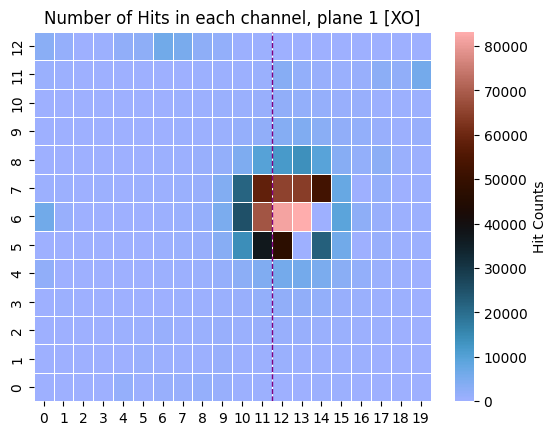

In [7]:
rf.hits_amount_colormap_single_plane(hit_data_1081,1)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

PAD RECONSTRUCTION

In [ ]:
"works!"
def pads_reconstruct(hit_data,plane, channel, plot = False, yscale = "linear"):

    # get the data from previous plane
    previous_plane = hit_data[hit_data.plane == plane - 1]
    prev_plane_same_ch = previous_plane[previous_plane.ch == channel]
    prev_plane_same_ch_zeros = ak.where(ak.num(prev_plane_same_ch.amp) == 0, [[0]], prev_plane_same_ch.amp)

    # get the data from plane 5
    next_plane = hit_data[hit_data.plane == plane + 1]
    next_plane_same_ch = next_plane[next_plane.ch == channel]
    next_plane_same_ch_zeros = ak.where(ak.num(next_plane_same_ch.amp) == 0, [[0]], next_plane_same_ch.amp)

    # average the data 
    reco_ch_data = (next_plane_same_ch_zeros + prev_plane_same_ch_zeros) / 2
    # plane_4_ch_105_reco_null = reco_ch_data[reco_ch_data > 0]
    # plane_4_ch_105_reco_clean = plane_4_ch_105_reco_null[ak.num(plane_4_ch_105_reco_null) > 0]

    if plot:
        # plot
        data_reco = np.array(reco_ch_data)
        print(data_reco.min())
        # Define bin width
        bin_width = 25
        # Create bins from min to max with step of 5
        bins = np.arange(data_reco.min(), data_reco.max() + bin_width, bin_width)
        # Plot histogram
        plt.figure()
        plt.hist(data_reco, bins=bins, alpha = 1, label = "Reconstructed")
        plt.grid(True)
        plt.legend()
        plt.xlim(0, data_reco.max())
        # Labels
        plt.xlabel("Energy")
        plt.ylabel("Counts")
        plt.title(f"plane {plane} ch {channel} -Origin and reconstructed data, Z axis avg")
        # plt.yscale("log")
        plt.yscale(yscale)
        plt.show()

    return reco_ch_data

In [ ]:
"works!"
# add the reconstructed data of the dead pad to the hits data
def add_reconstruct_data_single_dead_pad(data, plane, pad, scope_data = True):

    if scope_data:
        hit_data = data.hits

    # get the array of the reconstructed data
    reco_pad = pads_reconstruct(hit_data, plane, pad)

    # turn empty data in the reconstructed results to zeros
    reco_amp = ak.fill_none(ak.firsts(reco_pad), 0.0)

    # zip the reconstructed data to plane and ch of dead pad
    reco_pad_plane_ch = ak.zip(
        {
            "plane": ak.full_like(reco_amp, plane, dtype="int32"),
            "ch":    ak.full_like(reco_amp, pad, dtype="int32"),
            "amp":   reco_amp,
        })

    # turn the reconstructed data into subarrays per event
    reco1 = ak.unflatten(reco_pad_plane_ch, 1)

    # turn all zeros to empty spaces
    keep = reco_amp != 0
    reco_to_add = ak.fill_none(ak.mask(reco1, keep), [])

    # combine with original data
    hits_with_reco_pad = ak.concatenate([hit_data, reco_to_add], axis=1)

    data_with_reco_pad = ak.with_field(data, hits_with_reco_pad, "hits")

    return data_with_reco_pad

reco_146_1093 = add_reconstruct_data_single_dead_pad(hit_data_scope_1093, 4, 146)

In [ ]:
"works!"
# reconstruct the dead channels around the shower in a run - radius of reco dtermines the distance from the center of the shower to be reconstructed
def reconstruct_data_all_dead_pads(data, radius, path_to_diagnostics, number_of_planes = 8):

# find the center of the shower

    # single hit in the first plane
    first_plane1 = data.hits[data.hits.plane == 0]
    first_plane = first_plane1[ak.num(first_plane1) == 1]

    # ch activated in the first plane
    first_plane_ch = first_plane.ch

    # define center of the shower as the most activated pad in the first plane 
    counted_channels, counts = np.unique(ak.flatten(first_plane_ch), axis=0, return_counts=True)
    imax = np.argmax(counts)
    central_pad = counted_channels[imax]
    print("shower center:", central_pad)   
    



# get the dead channels list

    # list of all dead channels
    all_dead_channels = rf.channels_diagnostics(path_to_diagnostics, number_of_planes)
    print("amount of dead channels:", len(all_dead_channels))
    
    # get the pads in the wanted radius
    base = list(range(central_pad - radius, central_pad + radius +1))
    pads = [x + 20*i for i in range(-radius, radius+1) for x in base]
    
    # get the dead channels only from the wanted radius
    radius_mask = np.isin(all_dead_channels.channel_ID, pads)
    dead_channels_in_radius1 = all_dead_channels[radius_mask] 

    # delete dead channels starting at the first plane as we cant average for them
    dead_channels_in_radius = dead_channels_in_radius1[dead_channels_in_radius1.plane_ID > 0]


# add the reconstructed data
    counter = len(dead_channels_in_radius)
    for channel in dead_channels_in_radius:
        data = add_reconstruct_data_single_dead_pad(data, channel.plane_ID, channel.channel_ID)
        print(channel)
        counter -= 1
        print(counter, "channels left")
    
    
    return data

    # connect with the originial data
path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


<>:52: SyntaxWarning: invalid escape sequence '\T'
<>:52: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_3792\1956524001.py:52: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1093_raw_reco_diagnostics.root"


In [ ]:
# add the reconstructed data of the dead pad to the hits data
def add_reconstruct_data_single_dead_pad(data, plane, pad, scope_data = True):

    if scope_data:
        hit_data = data.hits

    # get the array of the reconstructed data
    reco_pad = pads_reconstruct(hit_data, plane, pad)

    # turn empty data in the reconstructed results to zeros
    reco_amp = ak.fill_none(ak.firsts(reco_pad), 0.0)

    # zip the reconstructed data to plane and ch of dead pad
    reco_pad_plane_ch = ak.zip(
        {
            "plane": ak.full_like(reco_amp, plane, dtype="int32"),
            "ch":    ak.full_like(reco_amp, pad, dtype="int32"),
            "amp":   reco_amp,
        })

    # turn the reconstructed data into subarrays per event
    reco1 = ak.unflatten(reco_pad_plane_ch, 1)

    # turn all zeros to empty spaces
    keep = reco_amp != 0
    reco_to_add = ak.fill_none(ak.mask(reco1, keep), [])

    # combine with original data
    hits_with_reco_pad = ak.concatenate([hit_data, reco_to_add], axis=1)

    data_with_reco_pad = ak.with_field(data, hits_with_reco_pad, "hits")

    return data_with_reco_pad

reco_146_1093 = add_reconstruct_data_single_dead_pad(hit_data_scope_1093, 4, 146)

In [120]:

a = reconstruct_data_all_dead_pads(hit_data_scope_1093, 5, path)
a

shower center: 124
we got the data
amount of dead channels: 140
{plane_ID: 1, channel_ID: 80}
54 channels left
{plane_ID: 2, channel_ID: 19}
53 channels left
{plane_ID: 2, channel_ID: 24}
52 channels left
{plane_ID: 2, channel_ID: 25}
51 channels left
{plane_ID: 2, channel_ID: 40}
50 channels left
{plane_ID: 2, channel_ID: 61}
49 channels left
{plane_ID: 2, channel_ID: 67}
48 channels left
{plane_ID: 2, channel_ID: 102}
47 channels left
{plane_ID: 2, channel_ID: 144}
46 channels left
{plane_ID: 2, channel_ID: 148}
45 channels left
{plane_ID: 2, channel_ID: 179}
44 channels left
{plane_ID: 3, channel_ID: 25}
43 channels left
{plane_ID: 3, channel_ID: 40}
42 channels left
{plane_ID: 3, channel_ID: 41}
41 channels left
{plane_ID: 3, channel_ID: 188}
40 channels left
{plane_ID: 4, channel_ID: 20}
39 channels left
{plane_ID: 4, channel_ID: 21}
38 channels left
{plane_ID: 4, channel_ID: 22}
37 channels left
{plane_ID: 4, channel_ID: 23}
36 channels left
{plane_ID: 4, channel_ID: 24}
35 chann

<Array [{tele: [{...}], hits: [...]}, ...] type='440902 * {tele: var * {x: ...'>

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

GAP 1081

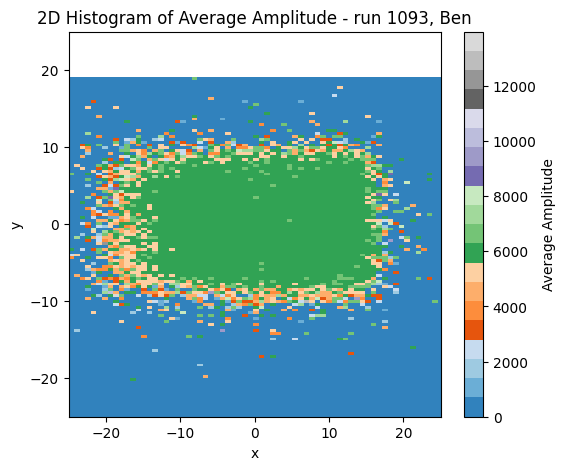

In [126]:
# xy_data = hit_data_scope_1093
xy_data = a
# xy_data = b
# xy_data = reco_146_1093
# reco_1093_146_144 = add_reconstruct_data_single_dead_pad(reco_146_1093, 2, 144)
# xy_data = reco_1093_146_144

X_ben1 = ak.flatten(xy_data.tele.x)
Y_ben1 = ak.flatten(xy_data.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(xy_data.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# Define bins
bins = 300

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben, Y_ben, bins=bins, weights=amp_ben)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben, Y_ben, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
# plt.xlim(min(X_ben), max(X_ben))
plt.xlim(-25, 25)
# plt.ylim(min(Y_ben), max(Y_ben))
plt.ylim(-25, 25)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1093, Ben")
plt.show()


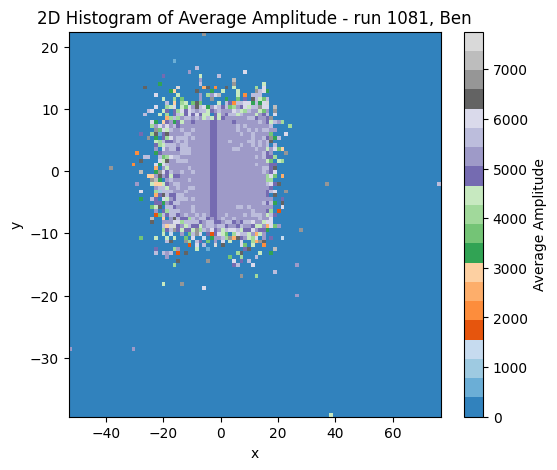

In [77]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 3)
X_ben1 = ak.flatten(hit_data_scope_1081.tele.x)
Y_ben1 = ak.flatten(hit_data_scope_1081.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(hit_data_scope_1081.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# mask = (X_ben > -10) & (X_ben < 10)
mask = (amp_ben < 8000)
# mask = amp_ben > 0
X_ben_mask = X_ben[mask]
Y_ben_mask = Y_ben[mask]
amp_ben_mask = amp_ben[mask]

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben_mask, Y_ben_mask, bins=bins, weights=amp_ben_mask)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben_mask, Y_ben_mask, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)


# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_ben_mask), max(X_ben_mask))
# plt.xlim(-30, 30)
plt.ylim(min(Y_ben_mask), max(Y_ben_mask))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Ben")
plt.show()


[5078, 5393, 5889, 6038, 6016, 5722, ..., 5722, 5968, 4709, 5183, 3284, 5307]
Gaussian fit parameters:
c     = 5496.921
m     = -0.662
theta     = -0.585 Radians
A     = 607.190
mu    = -2.456
sigma = 1.788


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


(np.float64(5506.851905006161), np.float64(5397.607589767299))


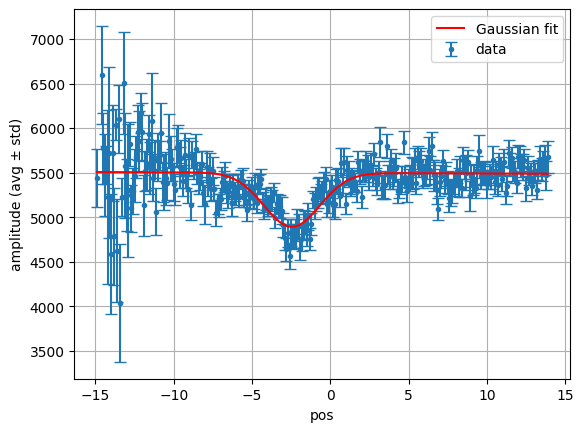

In [4]:
sf.E_vs_X_scope_gaussian_fit(hit_data_scope_1081, 0.5, -5, 3, -15, 14)

In [ ]:

tlu_ben = ak.firsts(hit_data_scope_1081_tlu.hits.TLU, axis = 1) 
tlu_gal = ak.firsts(gal_scope_1081.TLU)
gal_in_ben_mask = np.isin(tlu_gal,tlu_ben)
tlu_gal_in_ben = tlu_gal[~gal_in_ben_mask]

In [17]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]

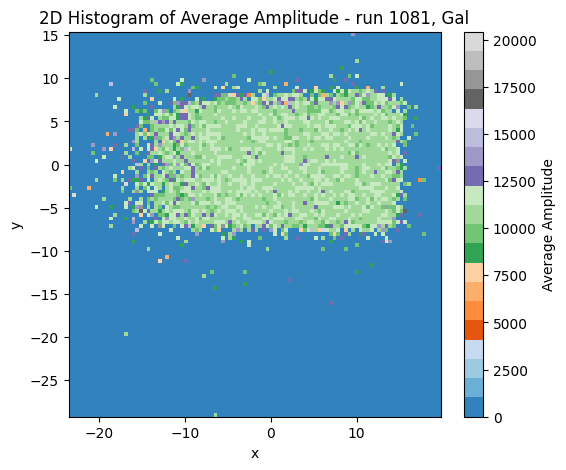

In [8]:
gal_ben_1081_scope = gal_scope_1081[~gal_in_ben_mask]
X_gal1 = ak.mean(gal_ben_1081_scope.x_dut, axis=1)
Y_gal1 = ak.mean(gal_ben_1081_scope.y_dut, axis=1)

X_gal = -ak.to_numpy(X_gal1)
Y_gal = ak.to_numpy(Y_gal1)

amp_gal1 = ak.sum(gal_ben_1081_scope.Amplitudes, axis=1)
amp_gal = ak.to_numpy(amp_gal1)

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_gal, Y_gal, bins=bins, weights=amp_gal)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_gal, Y_gal, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_gal), max(X_gal))
# plt.xlim(-30, 30)
plt.ylim(min(Y_gal), max(Y_gal))
# plt.ylim(-30, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1081, Gal")
plt.show()


[133, 134, 135, 136, 137, 153, 154, 155, 156, 157, 113, 114, 115, 116, 117]


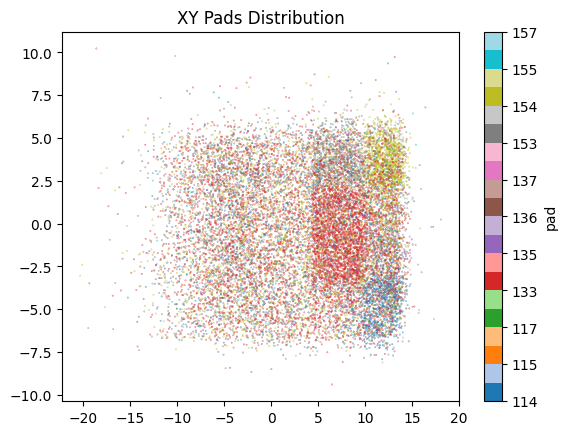

In [20]:
hit_data_scope_1081_filtered = sf.filter_chi2_scope_data(hit_data_scope_1081, 0.9) 
chosen_pads = sf.pads_xy(hit_data_scope_1081_filtered, 135)
# chosen_pads = pads_xy(hit_data_scope_1093, 125)

[123, 124, 125, 126, 127, 143, 144, 145, 146, 147, 103, 104, 105, 106, 107]


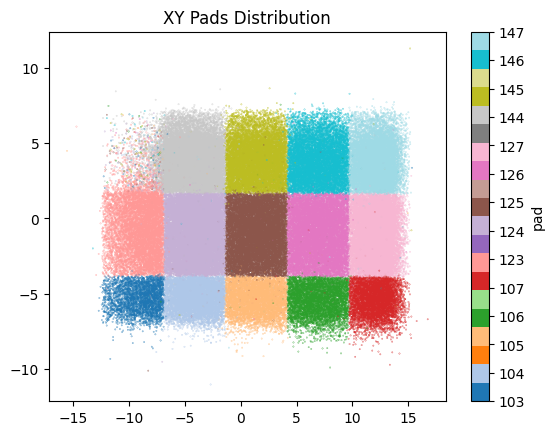

In [66]:
# plots the XY distribution of events that started in the wanted pads
def pads_xy(data, central_pad):

    # determine the chosen pads
    base = list(range(central_pad - 2, central_pad + 3))
    pads = base + list(map(lambda x: x + 20, base)) + list(map(lambda x: x - 20, base))
    print(pads)

    # data from the first plane only
    first_plane_mask = data.hits.plane == 0
    first_plane_data = data.hits[first_plane_mask]
    
    # events with single hit in first plane
    single_hit_mask = ak.num(first_plane_data) == 1
    single_hit_first_plane_data = data[single_hit_mask] 

    # data from the first plane with single hit
    first_plane_single_hit = first_plane_data[single_hit_mask]

    # get events that starts at the chosen pads
    chosen_pads_mask = np.isin(first_plane_single_hit.ch, pads)
    chosen_pads_data = single_hit_first_plane_data[chosen_pads_mask]

    # chosen pads data
    chosen_pads = chosen_pads_data.hits.ch

    # get the xy data for each
    x = -chosen_pads_data.tele.x
    y = chosen_pads_data.tele.y

   
   
    # plot xy by color
    unique_pads = np.unique(chosen_pads)
    pad_to_idx = {p: i for i, p in enumerate(unique_pads)}
    color_idx = np.array([pad_to_idx[p] for p in chosen_pads])

    plt.scatter(x, y, c=color_idx, cmap='tab20', s=0.05)
    plt.colorbar(ticks=np.arange(len(unique_pads)),label='pad').set_ticklabels(unique_pads)
    plt.title("XY Pads Distribution")
    plt.show()

    return chosen_pads_data
    


# chosen_pads = pads_xy(hit_data_scope_1081, 134)
chosen_pads = pads_xy(hit_data_scope_1093, 125)

[123, 124, 125, 126, 127, 143, 144, 145, 146, 147, 103, 104, 105, 106, 107]


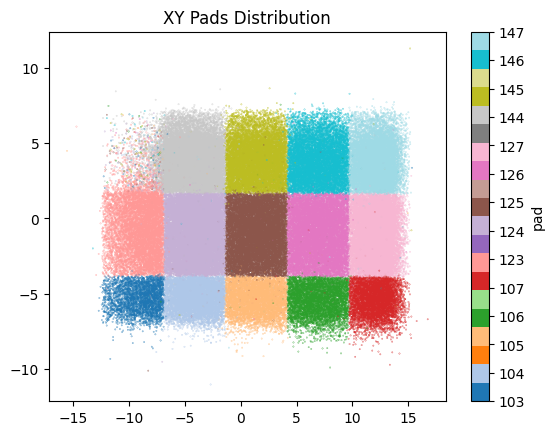

In [65]:
chosen_pads = sf.pads_xy(a, 125)

[132, 133, 134, 135, 136, 152, 153, 154, 155, 156, 112, 113, 114, 115, 116]


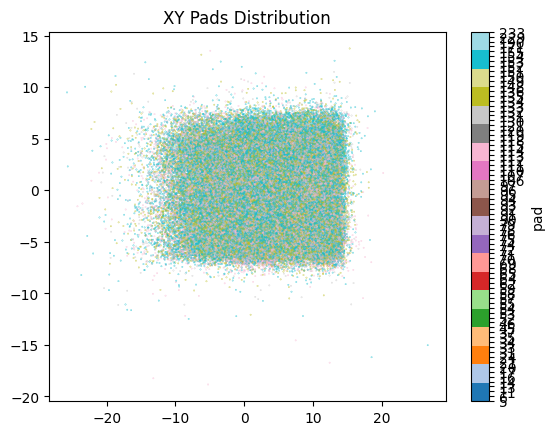

In [316]:
gal_scope_1081
gal_ch = gal_scope_1081.Channels
gal_planes = gal_scope_1081.Planes
gal_ch
gal_x = ak.firsts(gal_scope_1081.x_dut)
gal_y = ak.firsts(gal_scope_1081.y_dut)

hits = ak.zip({"plane": gal_planes, "ch": gal_ch})
gal_x = ak.singletons(gal_x)
gal_y = ak.singletons(gal_y)
tele = ak.zip({"x": gal_x, "y": gal_y})


gal_1081_xych = ak.zip({"hits": hits, "tele": tele}, depth_limit=1)
        


chosen_pads = pads_xy(gal_1081_xych, 134)

In [284]:
chosen_pads.hits

<Array [{plane: 0, ch: 132}, {...}, ..., {...}] type='17222 * {plane: int64...'>

In [271]:
# dataa =hit_data_scope_1081
dataa =gal_1081_xych

first_plane = dataa.hits[dataa.hits.plane == 0]
first_plane_single_hit = first_plane[ak.num(first_plane.plane) == 1]
dataa_first_plane_single_hits = dataa[ak.num(first_plane.plane) == 1]
first_plane_single_hit
mask = np.isin(first_plane_single_hit.ch, [132,153])
mask
dataa_first_plane_single_hits[mask]

# dataa.hits



<Array [{hits: {...}, tele: {...}}, ..., {...}] type='27315 * {hits: {plane...'>

In [266]:
hit_data_scope_1081.hits

<Array [[{plane: 0, ch: 151, ...}, ...], ...] type='390025 * var * {plane: ...'>

In [61]:
chosen_pads_mask = np.isin(first_plane.ch, [151,152])
first_plane[chosen_pads_mask].ch

<Array [151, 151, 152, 152, 151, ..., 151, 152, 152, 152] type='26617 * int32'>

In [48]:
# a[a.hits.ch == 151]
mask_single = first_plane[ak.num(first_plane) == 1]
chosen_ch_zeros = single_hit_events[(mask_single.ch == 151) | (mask_single.ch == 152)]
chosen_ch_zeros[ak.num(chosen_ch_zeros.hits) > 0].hits
# chosen_ch_zeros

<Array [[{plane: 0, ch: 151, ...}], ...] type='26617 * var * {plane: int32,...'>

In [60]:
hit_data_scope_1081.hits[hit_data_scope_1081.hits.plane == 0]
mask = hit_data_scope_1081.hits.plane == 0
mask
first_plane_1081 = hit_data_scope_1081.hits[mask]
# single_hit_first_plane_1081 = first_plane_1081[ak.num(first_plane_1081) == 1] 
# single_hit_first_plane_1081
# first_plane_1081[ak.num(first_plane_1081) == 1] 
hit_data_scope_1081[ak.num(first_plane_1081) == 1].tele

<Array [[{x: 3.9, y: 5.17, ...}], ..., [{...}]] type='153037 * var * {x: fl...'>